In [1]:
!pip install tiktoken datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00


In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from dataclasses import dataclass
import math
from torch.utils.data import Dataset, DataLoader
import tiktoken
import numpy as np

In [ ]:
# class DataLoaderLite:
#   def __init__(self, B, T):
#     self.B = B
#     self.T = T

#     with open("input.txt", "r") as f:
#       text = f.read()
#     enc = tiktoken.get_encoding("gpt2")
#     tokens = enc.encode(text)
#     self.tokens = torch.tensor(tokens)

#     print(f"laoded {len(tokens)} tokens")
#     print(f"1 Epoch = {len(self.tokens) // (B * T)} batches")
#     self.curr_pos = 0

#   def next_batch(self):
#     B, T = self.B, self.T
#     buf = self.tokens[self.curr_pos : self.curr_pos + B * T + 1]

#     x = buf[:-1].view(B, T)
#     y = buf[1:].view(B, T)

#     self.curr_pos += B * T
#     if self.curr_pos + B * T >= len(self.tokens):
#       self.curr_pos = 0
#     return x, y

In [16]:
class Dataloader:
    def __init__(self, B, T, split="train"):
        self.B = B
        self.T = T
        self.split = split.lower()

        # load pre tokenized data from binary files
        if self.split == "train":
            tokens_np = np.fromfile("train.bin", dtype=np.uint16)
            self.tokens = torch.tensor(tokens_np, dtype=torch.long)
        elif self.split == "val":
            tokens_np = np.fromfile("val.bin", dtype=np.uint16)
            self.tokens = torch.tensor(tokens_np, dtype=torch.long)
        else:
            raise ValueError("split must be 'train' or 'val'")
        self.curr_pos = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.curr_pos : self.curr_pos + B * T + 1]

        # Handle case where remaining tokens are less than B * T + 1
        if len(buf) < B * T + 1:
            # Pad with zeros or cycle back (cycling is more common for language modeling)
            pad_len = (B * T + 1) - len(buf)
            buf = torch.cat([buf, self.tokens[:pad_len]])

        x = buf[:-1].view(B, T)  # Input: all tokens except the last
        y = buf[1:].view(B, T)  # Target: all tokens except the first

        self.curr_pos += B * T
        # Reset position if we've reached or exceeded the end
        if self.curr_pos + B * T >= len(self.tokens):
            self.curr_pos = 0

        return x, y

In [4]:
@dataclass
class Config:
    block_size: int = 256
    vocab_size: int = 50304
    n_layers: int = 6
    n_head: int = 6
    n_embed: int = 384

In [5]:
class FeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4 * config.n_embed)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4 * config.n_embed, config.n_embed)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [6]:
class MultiHeadLatentAttention(nn.Module):
    """
    Multi Head Latent Attention (MLA) module for a transformer model.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.d_kv = 128
        self.d_c = 64
        self.d_r = 64
        self.d_q = 384
        self.d_h = config.n_embed // config.n_head

        self.norm_c_kv = nn.RMSNorm(self.d_kv)
        self.norm_dq = nn.RMSNorm(self.d_q)
        self.scale_kv = nn.Parameter(torch.ones(1))
        self.scale_q = nn.Parameter(torch.ones(1))

        # Shared projection matrices
        self.W_dkv = nn.Linear(config.n_embed, self.d_kv, bias=False)
        self.W_dq = nn.Linear(config.n_embed, self.d_q, bias=False)
        self.W_kr = nn.Linear(config.n_embed, self.d_r, bias=False)

        # Per-head projection matrices
        self.W_qc = nn.ModuleList(
            [nn.Linear(self.d_q, self.d_c, bias=False) for _ in range(config.n_head)]
        )
        self.W_qr = nn.ModuleList(
            [nn.Linear(self.d_q, self.d_r, bias=False) for _ in range(config.n_head)]
        )
        self.W_uk = nn.ModuleList(
            [nn.Linear(self.d_kv, self.d_c, bias=False) for _ in range(config.n_head)]
        )
        self.W_uv = nn.ModuleList(
            [nn.Linear(self.d_kv, self.d_h, bias=False) for _ in range(config.n_head)]
        )
        # Output projection
        self.W_o = nn.Linear(config.n_head * self.d_h, config.n_embed, bias=False)

        # Precompute RoPE (Rotary Position Embedding) cosines and sines
        freqs = torch.exp(
            torch.arange(0, self.d_r // 2, dtype=torch.float)
            * (-math.log(10000) / (self.d_r // 2))
        )
        positions = torch.arange(0, config.block_size)
        angles = positions[:, None] * freqs[None, :]
        self.register_buffer(
            "cos_angles", torch.cos(angles)
        )  # Shape: [block_size, d_r//2]
        self.register_buffer("sin_angles", torch.sin(angles))

    def apply_rope(self, x, seq_len):
        batch_size, _, d_r = x.size()
        cos = self.cos_angles[:seq_len]
        sin = self.sin_angles[:seq_len]
        x_pairs = x.view(batch_size, seq_len, d_r // 2, 2)
        rotated_x0 = (
            x_pairs[..., 0] * cos[None, :, :] - x_pairs[..., 1] * sin[None, :, :]
        )
        rotated_x1 = (
            x_pairs[..., 0] * sin[None, :, :] + x_pairs[..., 1] * cos[None, :, :]
        )
        rotated_pairs = torch.stack([rotated_x0, rotated_x1], dim=-1)
        return rotated_pairs.view(batch_size, seq_len, d_r)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        c_kv = (
            self.norm_c_kv(self.W_dkv(x)) * self.scale_kv
        )  # [batch_size, seq_len, 128]
        x_dq = self.norm_dq(self.W_dq(x)) * self.scale_q  # [batch_size, seq_len, 128]
        k_rope = self.W_kr(x)  # [batch_size, seq_len, 64]
        k_rope = self.apply_rope(k_rope, seq_len)

        outputs = []
        for h in range(self.config.n_head):
            # Query projections
            q_nope = self.W_qc[h](x_dq)  # [batch_size, seq_len, 64]
            q_rope = self.W_qr[h](x_dq)  # [batch_size, seq_len, 64]
            q_rope = self.apply_rope(q_rope, seq_len)

            # Key and value projections from latent space
            k_nope = self.W_uk[h](c_kv)  # [batch_size, seq_len, 64]
            v = self.W_uv[h](c_kv)  # [batch_size, seq_len, 128]

            # Compute attention scores
            score_nope = torch.bmm(
                q_nope, k_nope.transpose(1, 2)
            )  # [batch_size, seq_len, seq_len]
            score_rope = torch.bmm(
                q_rope, k_rope.transpose(1, 2)
            )  # [batch_size, seq_len, seq_len]
            score = score_nope + score_rope

            # Apply causal mask
            mask = torch.triu(
                torch.ones(seq_len, seq_len, device=x.device), diagonal=1
            ).bool()
            score = score.masked_fill(mask, float("-inf"))

            # Compute attention weights
            attn_weights = F.softmax(
                score / math.sqrt(self.d_h), dim=-1
            )  # Scale by sqrt(d_h) = sqrt(128)

            # Compute output for this head
            out = torch.bmm(attn_weights, v)  # [batch_size, seq_len, 128]
            outputs.append(out)

        # Concatenate outputs from all heads
        out = torch.cat(outputs, dim=-1)  # [batch_size, seq_len, 768]

        # Final output projection
        out = self.W_o(out)  # [batch_size, seq_len, 768]
        return out

In [7]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.rms_1 = nn.RMSNorm(config.n_embed)
        self.attn = MultiHeadLatentAttention(config)
        self.rms_2 = nn.RMSNorm(config.n_embed)
        self.ffn = FeedForwardNet(config)

    def forward(self, x):
        x = x + self.attn(self.rms_1(x))
        x = x + self.ffn(self.rms_2(x))
        return x

In [8]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embed),
                h=nn.ModuleList(Block(config) for _ in range(config.n_layers)),
                ln_f=nn.RMSNorm(config.n_embed),
            )
        )
        self.ln_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.ln_head.weight

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size

        tok_emb = self.transformer.wte(idx)
        x = tok_emb

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.ln_head(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
total_batch_size = 8192
B = 32
T = 256
assert (
    total_batch_size % (B * T) == 0
), "maken sure total_batch_size is divisible by B * T"
grad_accum_steps = total_batch_size // (B * T)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> Calculated gradient accumulation steps: {grad_accum_steps}")

Total desired batch size: 8192
=> Calculated gradient accumulation steps: 1


In [34]:
# train_loader = DataLoaderLite(B=B, T=T)

train_loader = Dataloader(B=B, T=T, split="train")
val_loader = Dataloader(B=B, T=T, split="val")

In [35]:
torch.set_float32_matmul_precision("high")

In [36]:
def get_lr(
    it,
    total_tokens=338025,
    max_lr=2.4e-4,
    warmup_steps=100,
    decay_factors=[0.316, 0.316],
    decay_points=[0.6, 0.9],
):
    # Convert decay points to token counts
    decay_token_counts = [int(p * total_tokens) for p in decay_points]

    # # Calculate total steps based on tokens
    # total_steps = total_tokens // tokens_per_step

    # # Adjust warmup_steps if it exceeds total_steps
    # warmup_steps = min(warmup_steps, total_steps)

    # # Calculate tokens processed at current iteration
    # tokens_processed = it * tokens_per_step

    if it < warmup_steps:
        # Linear warmup from 0 to max_lr
        lr = max_lr * (it / warmup_steps)
    else:
        # Base LR after warmup
        lr = max_lr
        # Apply step decay based on tokens processed
        for decay_tokens, factor in zip(decay_token_counts, decay_factors):
            if tokens_processed >= decay_tokens:
                lr *= factor
            else:
                break

    return lr

In [37]:
import time
import tiktoken

enc = tiktoken.get_encoding("gpt2")

config = Config(vocab_size=50304)

model = GPT(Config())
model.to(device)
model = torch.compile(model)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-4, betas=[0.9, 0.95], weight_decay=0.1
)
max_steps = 2500

train_losses = []
val_losses = []
val_steps_recorded = []

for step in range(max_steps):
    t0 = time.time()

    # model evaluation
    if step % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                logits, loss = model(x, y)

                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        val_loss_value = val_loss_accum.item()
        print(f"Validation loss: {val_loss_value:.4f}")
        val_losses.append(val_loss_value)
        val_steps_recorded.append(step)

    # if step > 0 and step % 100 == 0:
    #   model.eval()
    #   num_return_sequences = 4
    #   max_length = 10
    #   tokens = enc.encode("We are accounted poor citizens")
    #   tokens = torch.tensor(tokens, dtype=torch.long)
    #   # Add batch dimension: [length] -> [num_return_sequences, length]
    #   xgen = tokens.repeat(num_return_sequences, 1)  # Shape: [4, length]
    #   xgen = xgen.to(device)  # Move to device

    #   sample_rng = torch.Generator(device=device)
    #   sample_rng.manual_seed(42)

    #   while xgen.size(1) < max_length:
    #       with torch.no_grad():
    #           logits, _ = model(xgen)  # Shape: [num_return_sequences, sequence_length, vocab_size]

    #           logits = logits[:, -1, :]  # Get logits for the last token: [num_return_sequences, vocab_size]
    #           probs = F.softmax(logits, dim=-1)

    #           topk_probs, topk_indices = torch.topk(probs, 30, dim=-1)  # [num_return_sequences, 30]
    #           ix = torch.multinomial(topk_probs, 1, generator=sample_rng)  # [num_return_sequences, 1]
    #           xcol = torch.gather(topk_indices, -1, ix)  # [num_return_sequences, 1]
    #           xgen = torch.cat((xgen, xcol), dim=1)  # Append new tokens: [num_return_sequences, sequence_length+1]

    #   for i in range(num_return_sequences):
    #       tokens = xgen[i, :max_length].tolist()  # Fix: Correct variable name (tokens - xgen was a typo)
    #       decoded = enc.decode(tokens)
    #       print(f"sample {i}: {decoded}")

    # model training
    model.train()
    loss_accum = 0.0
    optimizer.zero_grad()
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)

        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    # gradient clipping -> as per deepseek-v2 paper
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)  # learning rate scheduler
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0  # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tokens_per_sec = tokens_processed / dt

    train_loss_value = loss_accum.item()
    train_losses.append(train_loss_value)
    print(
        f"step {step:4d}, loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} dt: {dt*1000:.2f}ms, tok/sec: {tokens_per_sec:.2f}"
    )

Validation loss: 11.0918
step    0, loss: 11.072306 | lr: 0.0000e+00 | norm: 8.1408 dt: 4024.03ms, tok/sec: 2035.77
step    1, loss: 11.037090 | lr: 2.4000e-06 | norm: 8.1998 dt: 525.11ms, tok/sec: 15600.46
step    2, loss: 11.024903 | lr: 4.8000e-06 | norm: 8.7676 dt: 521.66ms, tok/sec: 15703.86
step    3, loss: 10.969564 | lr: 7.2000e-06 | norm: 8.4936 dt: 530.97ms, tok/sec: 15428.24
step    4, loss: 10.911911 | lr: 9.6000e-06 | norm: 7.9908 dt: 529.59ms, tok/sec: 15468.52
step    5, loss: 10.811134 | lr: 1.2000e-05 | norm: 7.4857 dt: 530.67ms, tok/sec: 15437.02
step    6, loss: 10.712528 | lr: 1.4400e-05 | norm: 7.1566 dt: 532.78ms, tok/sec: 15375.98
step    7, loss: 10.574846 | lr: 1.6800e-05 | norm: 6.8427 dt: 532.24ms, tok/sec: 15391.64
step    8, loss: 10.392406 | lr: 1.9200e-05 | norm: 6.6753 dt: 530.19ms, tok/sec: 15451.16
step    9, loss: 10.322874 | lr: 2.1600e-05 | norm: 5.5015 dt: 533.59ms, tok/sec: 15352.72
step   10, loss: 10.312893 | lr: 2.4000e-05 | norm: 5.0128 dt: 53

KeyboardInterrupt: 

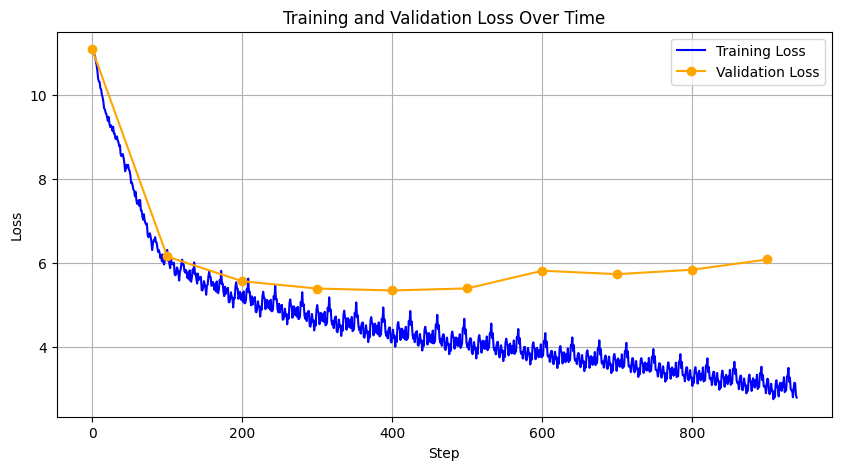

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Plot training loss (use the actual number of steps completed)
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
# Plot validation loss (recorded every 100 steps)
plt.plot(val_steps_recorded, val_losses, label="Validation Loss", color="orange", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()